<a href="https://colab.research.google.com/github/Cleanliness/BazaarPredictor/blob/main/BzrModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ML stuff
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from sklearn.preprocessing import StandardScaler

# data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# misc.
from google.colab import files
import random

# constants for hourly model
WINDOW_SIZE = 29
PREDICT_SIZE = 1

In [ ]:
# connect GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Sign in with bazaar ticker email to get training data from bazaar ticker google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read the hourly data csv


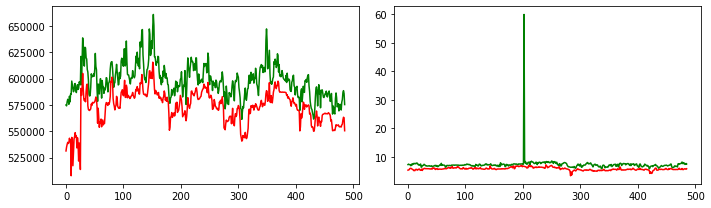

In [ ]:
buy_df = pd.read_csv('/content/drive/My Drive/hourly_dat/set1_buy_hour.csv')
sell_df = pd.read_csv('/content/drive/My Drive/hourly_dat/set1_sell_hour.csv')

# getting + normalizing timestamps, column names
timestamps = buy_df["Unnamed: 0"]
cols = list(buy_df)[1:-1]
hrs = np.sin(timestamps*(2*np.pi / 240000))

# converting df to numpy array, transpose so that rows are items, columns are timestamps
df_train_bp = buy_df[cols].astype(float).to_numpy()
df_train_bp = df_train_bp.transpose()

df_train_sp = sell_df[cols].astype(float).to_numpy()
df_train_sp = df_train_sp.transpose()

# plot raw buy and sell data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes[0].plot(list(buy_df["SUMMONING_EYE"]), color='g')
axes[1].plot(list(buy_df["IRON_INGOT"]), color='g')

axes[0].plot(list(sell_df["SUMMONING_EYE"]), color='r')
axes[1].plot(list(sell_df["IRON_INGOT"]), color='r')

fig.tight_layout()

Get rid of huge spikes in the dataset by smoothing them out (see iron ingot graph) - We want the model to learn short term trends in bazaar prices. Smooth out outliers (4 standard deviations from mean) by replacing them with local mean (window size = 15). Repeat this 5 times, since smaller spikes may exist, or large spikes might need multiple smoothings.

In [ ]:
def remove_outliers(bzr_dat, run_lim=5):
    runs = 0
    old_adjusted = bzr_dat
    adjusted_prices = []

    while runs < run_lim:
        for item_row in old_adjusted:
            item_mean, item_sdev = np.mean(item_row), np.std(item_row)
            l_bound, u_bound = item_mean - 4 * item_sdev, item_mean + 4 * item_sdev

            adjusted_row = []
            for price_ind in range(0, len(item_row)):
                itm_price = item_row[price_ind]

                # outlier detected, replace it with an intermediate value (less harmful to training model?)
                if itm_price < l_bound or itm_price > u_bound:
                    window_sum, i_l, i_r, count = 0, 1, 1, 0

                    # get average of neighboring values
                    while i_l + i_r - 2 < 15:
                        if price_ind - 1 in range(0, len(item_row)):
                            window_sum += item_row[price_ind - 1]
                            i_l += 1
                            count += 1

                        if price_ind + 1 in range(0, len(item_row)):
                            window_sum += item_row[price_ind + 1]
                            i_r += 1
                            count += 1

                    if count == 0:
                        # shouldn't happen, but catch this case to avoid div by 0
                        res = 0
                        print("no neighboring values, set adjusted point to 0")
                    else:
                        res = window_sum / count

                    # adding adjusted point to this row, i.e item price sequence
                    adjusted_row.append(res)

                else:
                    adjusted_row.append(itm_price)

            adjusted_prices.append(adjusted_row)

        old_adjusted = adjusted_prices
        adjusted_prices = []
        runs += 1
    return old_adjusted


Remove outliers for buy and sell prices. Notice that the spike in the iron ingot graph is now removed, and the summoning eye graph remains unchanged.

finished outlier removal from dataset


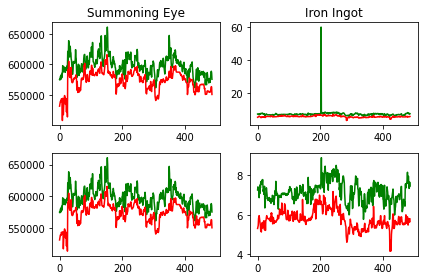

In [ ]:
df_train_bp = remove_outliers(df_train_bp)
df_train_sp = remove_outliers(df_train_sp)
print("finished outlier removal from dataset")

# plotting adjusted buy and sell dataframes
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(list(buy_df["SUMMONING_EYE"]), color='g')
ax1.plot(list(sell_df["SUMMONING_EYE"]), color='r')
ax2.plot(list(buy_df["IRON_INGOT"]), color='g')
ax2.plot(list(sell_df["IRON_INGOT"]), color='r')

ax3.plot(list(df_train_bp[cols.index("SUMMONING_EYE")]), color='g')
ax4.plot(list(df_train_bp[cols.index("IRON_INGOT")]), color='g')
ax3.plot(list(df_train_sp[cols.index("SUMMONING_EYE")]), color='r')
ax4.plot(list(df_train_sp[cols.index("IRON_INGOT")]), color='r')

ax2.set_title("Iron Ingot")
ax1.set_title("Summoning Eye")
f.tight_layout()

Use a sliding window over the dataframes to generate our dataset. Dataset is formatted as follows, where x is the input tensor, and y is the label. (make better img later)

m = number of input timesteps

n = number of samples

number of variables = 3 (buy, sell, time of day)
*** disregard the dimensions***

<img src='https://drive.google.com/uc?id=1E1DPlZt4fnu9XWCdTmzld7MFQaNOEqZC' width=500>

In [ ]:
def create_dataset(prices, timestamps, window_size, pred_size):
    """Generates and returns inputs and labels. Assume buy and sell have the same shape"""
    inputs, labels = [], []
    scaler = StandardScaler()

    for row_i in range(0, len(prices)):
        for frame_start in range(0, len(prices[row_i]) - (window_size + pred_size)):

            # getting entire window and normalizing it
            p_row = np.array([prices[row_i][frame_start: window_size + frame_start + pred_size]]).transpose()
            scaler.fit(p_row)
            p_row = scaler.transform(p_row).transpose()

            # getting input and label windows
            p_in = p_row[0][: window_size]
            time_in = timestamps[frame_start: window_size + frame_start]

            p_lbl = p_row[0][window_size:]

            # adding windows to inputs and labels list
            inputs.append(np.array([p_in, time_in]).transpose())
            labels.append(p_lbl)
            
    return np.array(inputs), np.array(labels)

Generate our dataset from set 1 and 2. for input we have shape corresponding to: (# of samples, # of variables, length of timespan). Output is the buy and sell predictions but flattened onto a vector

In [ ]:
# generating dataset from set 2
buy_df2 = pd.read_csv('/content/drive/My Drive/hourly_dat/set2_buy_hour.csv')
sell_df2 = pd.read_csv('/content/drive/My Drive/hourly_dat/set2_sell_hour.csv')

# getting + normalizing timestamps, column names
timestamps2 = buy_df2["Unnamed: 0"]
cols2 = list(buy_df2)[1:-1]
hrs2 = np.sin(timestamps2*(2*np.pi / 240000))

# converting df to numpy array, transpose so that rows are items, columns are timestamps
df_train_bp2 = buy_df2[cols2].astype(float).to_numpy()
df_train_bp2 = df_train_bp2.transpose()

df_train_sp2 = sell_df2[cols2].astype(float).to_numpy()
df_train_sp2 = df_train_sp2.transpose()

# remove outliers
df_train_bp2 = remove_outliers(df_train_bp2)
df_train_sp2 = remove_outliers(df_train_sp2)
print("finished outlier removal from dataset")

# create dataset
train_x2, train_y2 = create_dataset(df_train_bp2, hrs2, WINDOW_SIZE, PREDICT_SIZE)
print("dataset created")
print(train_x2.shape)
print(train_y2.shape)

finished outlier removal from dataset
dataset created
(140360, 29, 2)
(140360, 1)


Repeat this for sets 3-5

In [ ]:
# loading sets 3-5 into dataframe

# ----- set 3 ------
buy_df3 = pd.read_csv('/content/drive/My Drive/hourly_dat/set3_buy_hour.csv')
sell_df3 = pd.read_csv('/content/drive/My Drive/hourly_dat/set3_sell_hour.csv')

timestamps3 = buy_df3["Unnamed: 0"]
cols3 = list(buy_df3)[1:-1]
hrs3 = np.sin(timestamps3*(2*np.pi / 240000))

df_train_bp3 = buy_df3[cols3].astype(float).to_numpy()
df_train_bp3 = df_train_bp3.transpose()

df_train_sp3 = sell_df3[cols3].astype(float).to_numpy()
df_train_sp3 = df_train_sp3.transpose()

df_train_bp3 = remove_outliers(df_train_bp3)
df_train_sp3 = remove_outliers(df_train_sp3)
print("finished set 3")

# ---- set 4 -------
buy_df4 = pd.read_csv('/content/drive/My Drive/hourly_dat/set4_buy_hour.csv')
sell_df4 = pd.read_csv('/content/drive/My Drive/hourly_dat/set4_sell_hour.csv')

timestamps4 = buy_df4["Unnamed: 0"]
cols4 = list(buy_df4)[1:-1]
hrs4 = np.sin(timestamps4*(2*np.pi / 240000))

df_train_bp4 = buy_df4[cols4].astype(float).to_numpy()
df_train_bp4 = df_train_bp4.transpose()

df_train_sp4 = sell_df4[cols4].astype(float).to_numpy()
df_train_sp4 = df_train_sp4.transpose()

df_train_bp4 = remove_outliers(df_train_bp4)
df_train_sp4 = remove_outliers(df_train_sp4)
print("finished set 4")

# ---- set 4 -------
buy_df5 = pd.read_csv('/content/drive/My Drive/hourly_dat/set5_buy_hour.csv')
sell_df5 = pd.read_csv('/content/drive/My Drive/hourly_dat/set5_sell_hour.csv')

timestamps5 = buy_df5["Unnamed: 0"]
cols5 = list(buy_df5)[1:-1]
hrs5 = np.sin(timestamps5*(2*np.pi / 240000))

df_train_bp5 = buy_df5[cols5].astype(float).to_numpy()
df_train_bp5 = df_train_bp5.transpose()

df_train_sp5 = sell_df5[cols5].astype(float).to_numpy()
df_train_sp5 = df_train_sp5.transpose()

df_train_bp5 = remove_outliers(df_train_bp5)
df_train_sp5 = remove_outliers(df_train_sp5)
print("finished set 5")

finished set 3
finished set 4
finished set 5


Concatenate the datasets from set 1 and 2. The plot below is an example of an input and label (i.e expected values)

finished creating dataset 1
finished dataset 3
finished dataset 4
finished dataset 5
(467541, 29, 2)
(467541, 1)


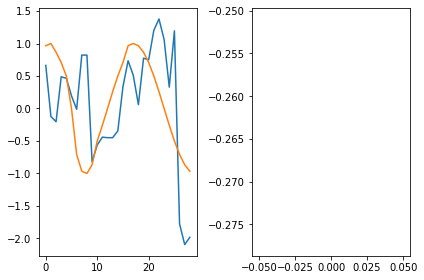

In [ ]:
train_x1, train_y1 = create_dataset(df_train_bp, hrs, WINDOW_SIZE, PREDICT_SIZE)
print("finished creating dataset 1")
train_x3, train_y3 = create_dataset(df_train_bp3, hrs3, WINDOW_SIZE, PREDICT_SIZE)
print("finished dataset 3")
train_x4, train_y4 = create_dataset(df_train_bp4, hrs4, WINDOW_SIZE, PREDICT_SIZE)
print("finished dataset 4")
train_x5, train_y5 = create_dataset(df_train_bp5, hrs5, WINDOW_SIZE, PREDICT_SIZE)
print("finished dataset 5")
# concatenate 2 datasets
train_x, train_y = np.concatenate((train_x1, train_x2)), np.concatenate((train_y1, train_y2))
train_x, train_y = np.concatenate((train_x, train_x3)), np.concatenate((train_y, train_y3))
train_x, train_y = np.concatenate((train_x, train_x4)), np.concatenate((train_y, train_y4))
train_x, train_y = np.concatenate((train_x, train_x5)), np.concatenate((train_y, train_y5))

f, (ax1, ax4) = plt.subplots(1, 2)
ax1.plot(list(train_x[0]))
ax4.plot(list(train_y2[0]))

print(train_x.shape)
print(train_y.shape)

f.tight_layout()

Define model architecture

In [ ]:
bzr_model = Sequential()

bzr_model.add(LSTM(100, input_shape=(WINDOW_SIZE, 2), return_sequences=True))
bzr_model.add(LSTM(100, activation='relu', return_sequences=True))
bzr_model.add(LSTM(100, activation='relu'))
bzr_model.add(Dense(PREDICT_SIZE))

bzr_opt = tf.keras.optimizers.Adadelta(
    learning_rate=0.0005, rho=0.95, epsilon=1e-07, name="Adadelta"
)

bzr_model.compile(optimizer=bzr_opt, loss='mse', metrics=['accuracy'])
bzr_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 29, 100)           41200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 29, 100)           80400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 202,101
Trainable params: 202,101
Non-trainable params: 0
_________________________________________________________________


train the model

In [ ]:
with tf.device('/device:GPU:0'):
  history = bzr_model.fit(train_x, train_y, epochs=1, batch_size=4000, validation_split=0.1, verbose=1)

106/106 [==============================] - 17s 164ms/step - loss: 1.7217 - accuracy: 0.0047 - val_loss: 1.7349 - val_accuracy: 0.0014


In [ ]:
# run this with model while training to keep colab session running
while True:pass

KeyboardInterrupt: ignored

Plotting stats after training


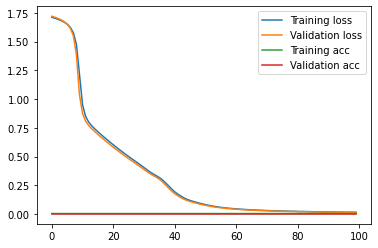

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.legend()

comparing predictions to actual

finished copying


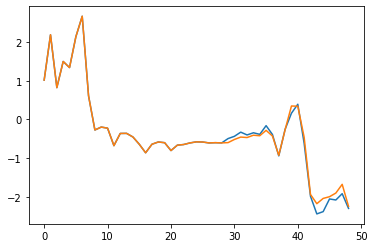

In [ ]:
# compare predictions to actual
steps = 20
row = random.randint(len(train_x)*0.91 // 1, len(train_x) - steps - 1)


pred = list(np.transpose(train_x[row])[0][:])
actual = list(np.transpose(train_x[row])[0][:])
time = list(np.transpose(train_x[row])[1][:])

print("finished copying")
for i in range(row, row + steps):
  # prediction = blue, actual = orange
  prediction = bzr_model.predict(train_x[i: i+1])

  pred.append(prediction[0][0])
  actual.append(train_x[i + 1][-1][0])
  time.append(train_x[i + 1][-1][1])
  # plt.plot(prediction[0])
  # plt.plot(train_y[row])

# orange = actual
# blue = predicted

plt.plot(pred)
plt.plot(actual)

In [ ]:
# save model if looks successful
bzr_model.save("data/bzr_1h_model9.h5")

In [ ]:
# download model
files.download("data/bzr_1h_model9.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# (optional) load previous model
bzr_model = keras.models.load_model("/content/drive/My Drive/prediction models/1h/0.0165 loss/bzr_1h_model9.h5") 

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 112kB 8.4MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
# TODO, test data on set 3, make graphs of 1h predictions vs 2h vs 3h
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(bzr_model, "data/")



/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [ ]:
files.download("data/model.json")
files.download("data/group1-shard1of1.bin")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>